<a href="https://colab.research.google.com/github/chitra-psg/rossmann_sales_prediction/blob/main/Rossman_Sales_Prediction_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Rossman Sales Forecasting**

***Problem*** : Rossmann is a European drug distributor which operates over 3,000 drug stores across seven European countries. Since a lot of drugs come with a short shelf life, that is, they do not have a long expiry date, it becomes imperative for Rossmann to accurately forecast sales at their individual stores. Currently, the forecasting is taken care of by the store managers who are tasked with forecasting daily sales for the next six weeks.As expected, store sales are influenced by many factors, including promotional campaigns, competition, state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances and intuitions, the accuracy of the forecasts is quite varied.

*Build a forecasting model to forecast the daily sales for the next six weeks*

In [84]:
#importing important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

### **Data Processing**

#### **Source Data**

In [85]:
store = pd.read_csv('store.csv')
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [86]:
sales = pd.read_csv('train.csv')
sales.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263.0,555.0,1.0,1.0,0,1.0
1,2,5,2015-07-31,6064.0,625.0,1.0,1.0,0,1.0
2,3,5,2015-07-31,8314.0,821.0,1.0,1.0,0,1.0
3,4,5,2015-07-31,13995.0,1498.0,1.0,1.0,0,1.0
4,5,5,2015-07-31,4822.0,559.0,1.0,1.0,0,1.0


In [87]:
store_sales_full = sales.merge(right=store, on='Store', how='left')

In [88]:
store_sales_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336223 entries, 0 to 336222
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      336223 non-null  int64  
 1   DayOfWeek                  336223 non-null  int64  
 2   Date                       336223 non-null  object 
 3   Sales                      336222 non-null  float64
 4   Customers                  336222 non-null  float64
 5   Open                       336222 non-null  float64
 6   Promo                      336222 non-null  float64
 7   StateHoliday               336222 non-null  object 
 8   SchoolHoliday              336222 non-null  float64
 9   StoreType                  336223 non-null  object 
 10  Assortment                 336223 non-null  object 
 11  CompetitionDistance        335373 non-null  float64
 12  CompetitionOpenSinceMonth  229252 non-null  float64
 13  CompetitionOpenSinceYear   22

In [89]:
#store_sales = store_sales_full[
#        (store_sales_full.Store == 1) | (store_sales_full.Store == 3)| (store_sales_full.Store == 8)| (store_sales_full.Store == 9)| (store_sales_full.Store == 13) |
#        (store_sales_full.Store == 25) | (store_sales_full.Store == 29)| (store_sales_full.Store == 31)| (store_sales_full.Store == 46)
#     ]


In [90]:
store_sales = store_sales_full

In [91]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336223 entries, 0 to 336222
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      336223 non-null  int64  
 1   DayOfWeek                  336223 non-null  int64  
 2   Date                       336223 non-null  object 
 3   Sales                      336222 non-null  float64
 4   Customers                  336222 non-null  float64
 5   Open                       336222 non-null  float64
 6   Promo                      336222 non-null  float64
 7   StateHoliday               336222 non-null  object 
 8   SchoolHoliday              336222 non-null  float64
 9   StoreType                  336223 non-null  object 
 10  Assortment                 336223 non-null  object 
 11  CompetitionDistance        335373 non-null  float64
 12  CompetitionOpenSinceMonth  229252 non-null  float64
 13  CompetitionOpenSinceYear   22

In [92]:
#Check nulls for null treatment
store_sales.isna().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             1
Customers                         1
Open                              1
Promo                             1
StateHoliday                      1
SchoolHoliday                     1
StoreType                         0
Assortment                        0
CompetitionDistance             850
CompetitionOpenSinceMonth    106971
CompetitionOpenSinceYear     106971
Promo2                            0
Promo2SinceWeek              170860
Promo2SinceYear              170860
PromoInterval                170860
dtype: int64

#### ***Findings*** : When no Promo (Promo2 =0) then no Promo related details available in Promo2SinceWeek , Promo2SinceYear and PromoInterval

In [93]:
#Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
store_sales.Promo2.value_counts()

0    170860
1    165363
Name: Promo2, dtype: int64

In [94]:
store_sales = store_sales.astype({
    'CompetitionOpenSinceMonth': pd.Int8Dtype(),
    'CompetitionOpenSinceYear': pd.Int16Dtype(),
    'Promo2SinceWeek': pd.Int8Dtype(),
    'Promo2SinceYear': pd.Int16Dtype()
})

# Convert Date to a date-time-object
store_sales['Date'] = pd.to_datetime(store_sales['Date'], format='%Y-%m-%d')

store_sales.StateHoliday = store_sales.StateHoliday.replace(0,'N/A')

#NULL Treatment - we will set it as -1 to indicate there was no promotion.
#Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
store_sales['Promo2SinceWeek'] = store_sales['Promo2SinceWeek'].replace(np.nan,-1).astype(int)
store_sales['Promo2SinceYear'] = store_sales['Promo2SinceYear'].replace(np.nan,-1).astype(int)

store_sales['PromoInterval'] = store_sales['PromoInterval'].replace(np.nan,'N/A')

#Competition Distance and other competitor related fields values not available would indicate no competitor so can fill with -1
store_sales['CompetitionDistance'] = store_sales['CompetitionDistance'].replace(np.nan,-1).astype(int)
store_sales['CompetitionOpenSinceMonth'] = store_sales['CompetitionOpenSinceMonth'].replace(np.nan,-1).astype(int)
store_sales['CompetitionOpenSinceYear'] = store_sales['CompetitionOpenSinceYear'].replace(np.nan,-1).astype(int)


store_sales['Promo'] = store_sales['Promo'].astype(bool)
store_sales['Promo2'] = store_sales['Promo2'].astype(bool)

store_sales['PromoInterval'] = store_sales['PromoInterval'].replace(np.nan,'N/A')


In [95]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336223 entries, 0 to 336222
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      336223 non-null  int64         
 1   DayOfWeek                  336223 non-null  int64         
 2   Date                       336223 non-null  datetime64[ns]
 3   Sales                      336222 non-null  float64       
 4   Customers                  336222 non-null  float64       
 5   Open                       336222 non-null  float64       
 6   Promo                      336223 non-null  bool          
 7   StateHoliday               336222 non-null  object        
 8   SchoolHoliday              336222 non-null  float64       
 9   StoreType                  336223 non-null  object        
 10  Assortment                 336223 non-null  object        
 11  CompetitionDistance        336223 non-null  int64   

In [96]:
#Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
store_sales.Promo2.value_counts()

False    170860
True     165363
Name: Promo2, dtype: int64

In [97]:
store_sales.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [ ]:
# Select categorical columns
categorical_cols = ['Promo','StoreType', 'Assortment','CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']#Excluding Store

# Define rows and columns for subplots
rows = int(np.ceil(len(categorical_cols) / 2))  # Assuming 3 columns per row
cols = min(2, len(categorical_cols))

# Create figure and subplots
fig, axs = plt.subplots(rows, cols, figsize=(20, 10), squeeze=True)  # Ensure 1D array of subplots

for i, col in enumerate(categorical_cols):
    sns.countplot(x=col, data=store_sales, ax=axs.ravel()[i], palette="hls")
    axs.ravel()[i].set_title(col)
    axs.ravel()[i].xaxis.set_label_text(col)  # Access and set label on the correct subplot's axis

# Adjust spacing and show the plot
plt.tight_layout()
plt.show()


**Inferences**
> Maximum competitions are opened in the month of september or 9

> Maximum competitiors opened their store in the year 2013

> 48% stores don't have promo2

> StoreType = a is maximum among others

> Majority of assortments are 'a'





In [99]:
store_sales.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

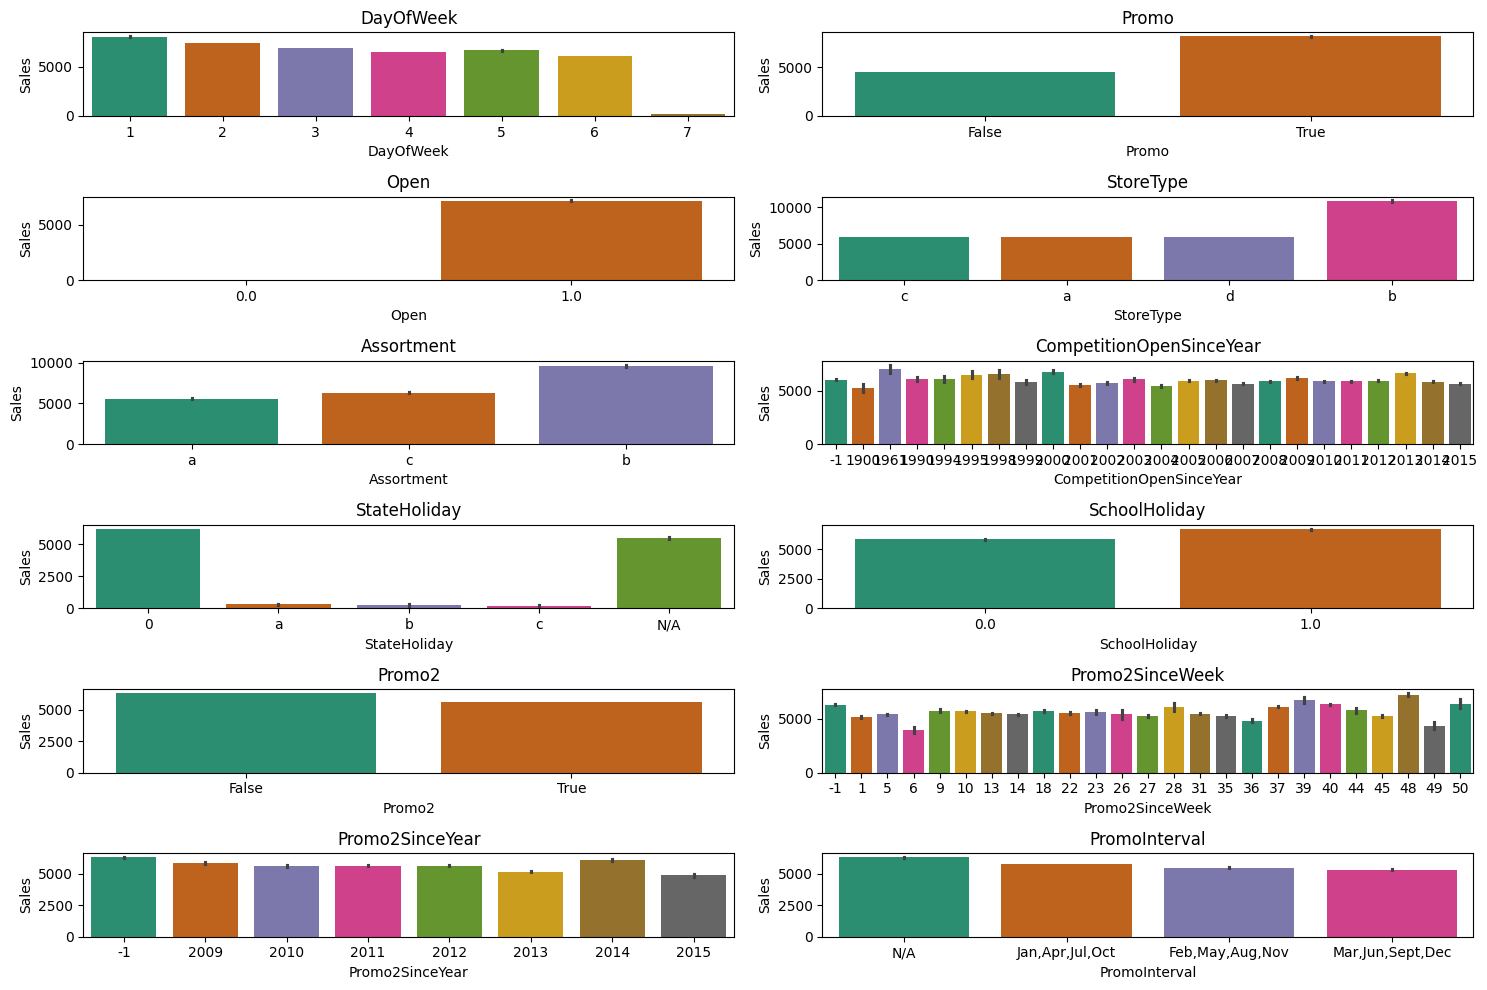

In [100]:
# Select categorical columns
sales_categorical_cols = ['DayOfWeek', 'Promo','Open', 'StoreType','Assortment', 'CompetitionOpenSinceYear', 'StateHoliday','SchoolHoliday','Promo2','Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

# Define rows and columns for subplots
rows = int(np.ceil(len(sales_categorical_cols) / 2))  # Assuming 2 columns per row
cols = min(2, len(sales_categorical_cols))

# Create figure and subplots
fig, axs = plt.subplots(rows, cols, figsize=(15, 10), squeeze=True)  # Ensure 1D array of subplots

for i, col in enumerate(sales_categorical_cols):
    sns.barplot(x=col, y='Sales', data=store_sales, ax=axs.ravel()[i], palette="Dark2")
    axs.ravel()[i].set_title(col)
    axs.ravel()[i].xaxis.set_label_text(col)  # Access and set label on the correct subplot's axis

# Adjust spacing and show the plot
plt.tight_layout()
plt.show()


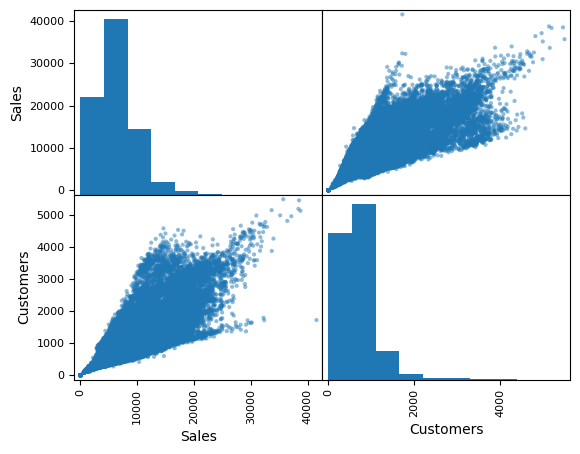

In [101]:
#Sales_Customers
from pandas.plotting import scatter_matrix
attributes = ["Sales", "Customers"]
scatter_matrix(store_sales[attributes]);

**Inferences**
*   All days of the week have almost equal sales
*   Mostly the store is open
*   Promotions are less active

In [102]:
# detecting outliers
store_sales.describe(percentiles=[0.90,0.95,0.99])

,Store,DayOfWeek,Sales,Customers,Open,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2SinceWeek,Promo2SinceYear
count,336223.000000,336223.000000,336222.000000,336222.000000,336222.000000,336222.000000,336223.000000,336223.000000,336223.000000,336223.000000,336223.000000
mean,558.493054,3.996175,5970.511537,638.695817,0.829235,0.154324,5435.760106,4.605895,1369.308319,10.810078,988.918664
std,321.849137,1.992095,3940.824148,466.432543,0.376304,0.361259,7752.719268,4.658594,936.054552,15.537056,1006.239767
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,558.000000,4.000000,5974.000000,617.000000,1.000000,0.000000,2320.000000,4.000000,2006.000000,-1.000000,-1.000000
90%,1004.000000,7.000000,10595.000000,1115.000000,1.000000,1.000000,15710.000000,11.000000,2013.000000,37.000000,2013.000000
95%,1060.000000,7.000000,12470.000000,1359.000000,1.000000,1.000000,20390.000000,12.000000,2014.000000,40.000000,2014.000000
99%,1104.000000,7.000000,17400.000000,2305.000000,1.000000,1.000000,36410.000000,12.000000,2015.000000,45.000000,2014.000000
max,1115.000000,7.000000,41551.000000,5494.000000,1.000000,1.000000,75860.000000,12.000000,2015.000000,50.000000,2015.000000


In [107]:
store_sales_nooutlier = store_sales[store_sales['Sales'] <= store_sales['Sales'].quantile(.99)]
store_sales_nooutlier = store_sales_nooutlier[store_sales_nooutlier['Customers'] <= store_sales_nooutlier['Customers'].quantile(.99)]

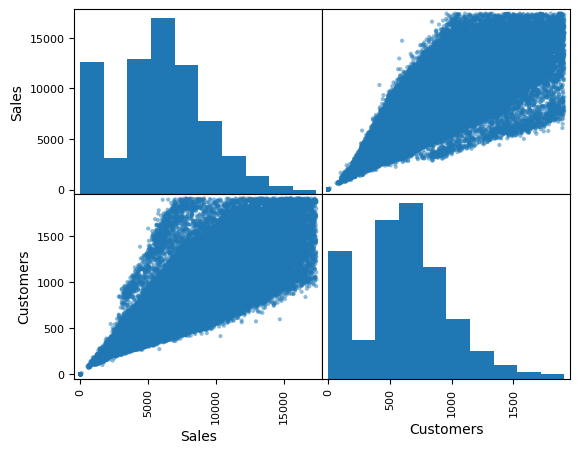

In [108]:
#Sales_Customers
from pandas.plotting import scatter_matrix
attributes = ["Sales", "Customers"]
scatter_matrix(store_sales_nooutlier[attributes]);

Findings
Higher number of customer leads to higher sales

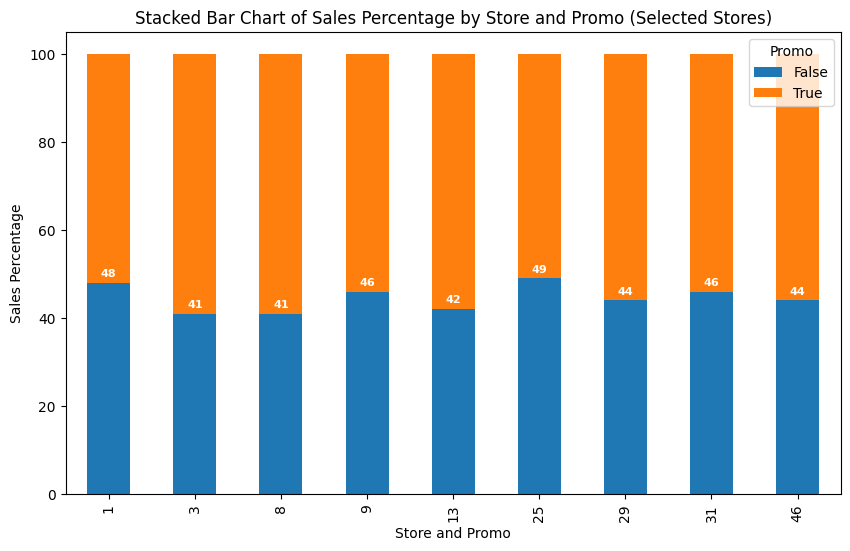

In [114]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming grouped_data is a DataFrame
grouped_data = store_sales_nooutlier.groupby(['Store', 'Promo'])['Sales'].sum().unstack()

# Filter stores
selected_stores = [1, 3, 8, 9, 13, 25, 29, 31, 46]
grouped_data = grouped_data[grouped_data.index.isin(selected_stores)]

# Calculate percentage based on the filtered grouped_data and round to 0 decimal places
percentage_data = (grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100).round(0)

# Plot the stacked bar chart
ax = percentage_data.plot(kind='bar', stacked=True, figsize=(10, 6))

# Display percentage labels on each bar
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=8, color='white', weight='bold', padding=3)

# Set labels and title
plt.xlabel('Store and Promo')
plt.ylabel('Sales Percentage')
plt.title('Stacked Bar Chart of Sales Percentage by Store and Promo (Selected Stores)')

# Show the plot
plt.show()


In [ ]:
def plot_store_trend(title, xaxis, yaxis, chart_type,order_list =None):

  left  = 0.125  # the left side of the subplots of the figure
  right = 0.9    # the right side of the subplots of the figure
  bottom = 0.1   # the bottom of the subplots of the figure
  top = 0.9      # the top of the subplots of the figure
  wspace = 0.2   # the amount of width reserved for blank space between subplots
  hspace = 0.8   # the amount of height reserved for white space between subplots

  store_dfs = [data_store1, data_store3, data_store8, data_store9, data_store13, data_store25, data_store29, data_store31, data_store46 ]
  label_dfs = ['store1', 'store3', 'store8', 'store9', 'store13', 'store25','store29', 'store31', 'store46']
  index = [1,3,8,9,13,25,29,31,46]

  # PROMO
  fig, axis = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(10,6))
  fig.suptitle(title)
  fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

  i = 0
  for x in range (0,3):
      for y in range (0,3):
          #i = x + y + int(incr)
          j = index[i]
          label =  label_dfs[i]
          d = store_dfs[i]
          axis[x,y].title.set_text(label)
          if chart_type == 'bar':
            if order_list is None:
              sns.barplot(x=xaxis, y=yaxis, data=d, ax=axis[x,y], palette="hls")
            else:
              sns.barplot(x=xaxis, y=yaxis, data=d, ax=axis[x,y], order = order_list, palette="hls")

          if chart_type == 'line':
              sns.lineplot(x=xaxis, y=yaxis, data=d, ax=axis[x,y], palette="hls")
          elif chart_type == 'box':
              sns.boxplot(x=d[xaxis],whis=1.5, palette="hls")
          i = i + 1

In [ ]:
plot_store_trend('Customers vs Sales for the Key Stores', 'Customers', 'Sales', 'line')

In [ ]:
plot_store_trend('DayOfWeek vs ALL Nine Stores Sales data', 'DayOfWeek', 'Sales', 'bar',[1,2,3,4,5,6,7])

In [ ]:
plot_store_trend('Promo vs Non Promo Sales for Key Stores', 'Promo', 'Sales', 'bar')

In [ ]:
plot_store_trend('Promo2 vs ALL Nine Stores Sales data', 'Promo2', 'Sales', 'bar')

In [ ]:
plot_store_trend('SchoolHoliday vs ALL Nine Stores Sales data', 'SchoolHoliday', 'Sales', 'bar')

In [ ]:
filtered_df.info()

In [ ]:
filtered_df.StateHoliday = filtered_df.StateHoliday.replace(0,'N/A')

In [ ]:
#filtered_df = filtered_df.reset_index()


In [ ]:
# box-plot creation for variious variables w.r.t sales
plt.figure(figsize=(20,20))
plt.subplot(4,4,1)
sns.boxplot(x = filtered_df.DayOfWeek, y = filtered_df.Sales)

plt.subplot(4,4,2)
sns.boxplot(x = filtered_df.Promo2, y = filtered_df.Sales)

plt.subplot(4,4,4)
sns.boxplot(x = filtered_df.Promo, y = filtered_df.Sales)

plt.subplot(4,4,5)
sns.boxplot(x = filtered_df.StateHoliday, y = filtered_df.Sales)

plt.subplot(4,4,6)
sns.boxplot(x = filtered_df.SchoolHoliday, y = filtered_df.Sales)

plt.subplot(4,4,7)
sns.boxplot(x = filtered_df.StoreType, y = filtered_df.Sales)

plt.subplot(4,4,8)
sns.boxplot(x = filtered_df.Assortment, y = filtered_df.Sales)

plt.subplot(4,4,9)
sns.boxplot(x = filtered_df.CompetitionOpenSinceMonth, y = filtered_df.Sales)

plt.subplot(4,4,10)
sns.boxplot(x = filtered_df.Promo2SinceWeek, y = filtered_df.Sales)
plt.xticks(rotation=90)

plt.subplot(4,4,11)
sns.boxplot(x = filtered_df.Promo2SinceYear, y = filtered_df.Sales)

plt.subplot(4,4,12)
sns.boxplot(x = filtered_df.PromoInterval, y = filtered_df.Sales)
plt.xticks(rotation=90)

plt.subplot(4,4,13)
sns.boxplot(x = filtered_df.CompetitionOpenSinceYear, y = filtered_df.Sales)

plt.xticks(rotation=90)
plt.show()

In [ ]:
# trend/seasonality search
filtered_df.groupby(['CompetitionOpenSinceMonth'])['Sales'].mean().plot.barh(figsize=(10,7), color='orange')
plt.show()

In [ ]:
sns.distplot(filtered_df['CompetitionOpenSinceYear'])

In [ ]:
sns.distplot(filtered_df['CompetitionOpenSinceMonth'])

In [ ]:
#Plotting distribution of Competition Distance.
sns.distplot(filtered_df['CompetitionDistance'])
plt.xlabel('Competition Distance in meters',fontsize=11.5)

In [ ]:
filtered_df.groupby('StoreType')['Sales'].describe()

In [ ]:
avg_sales__avg_customers = filtered_df.groupby('Store').mean()[['Sales', 'Customers']]
sns.scatterplot('Customers', 'Sales', data=avg_sales__avg_customers)
plt.show()

In [ ]:
display(Markdown(f"Pearson cofficient is `{'%.2f' % filtered_df[['Sales', 'Customers']].corr().iloc[0,1]}`"))